# <div style="text-align: center;" markdown="1"><span style="font-size:1.7em;">Task 4 </span>

In [1]:
# Import the needed libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Optimal Thresholding ##

In [2]:
def optimal_thresholding(img, flag=1, t=None):
    cols, rows = img.shape
    
    # The function enters here for the first time only
    if flag == 1:
        bg_pixels = [img[0, 0], img[0, rows-1], img[cols-1, 0], img[cols-1, rows-1]]  # Fix indexing
        bg_pixels_sum = sum(bg_pixels)
        bg_mean = float(bg_pixels_sum) / len(bg_pixels)
        obj_pixels = img[1:cols-1, 1:rows-1]  # Exclude the 4 corner pixels to get the first assumption of the object
        obj_pixels_sum = sum(map(sum, obj_pixels))
        obj_mean = float(obj_pixels_sum) / len(obj_pixels) if len(obj_pixels) > 0 else 0  # Handle division by zero
        t = (bg_mean + obj_mean) / 2  # Get the first threshold by getting the average of the background and the object
        return optimal_thresholding(img, 0, t)  # Return the result of the recursive call
    
    else:
        obj_pixels = []
        bg_pixels = []
        
        # Separate the object from the background based on the value of t
        for col in range(cols):
            for row in range(rows):
                p = img[col, row]  # Fix indexing
                if p < t:
                    obj_pixels.append(p)
                else:
                    bg_pixels.append(p)
        bg_mean = sum(bg_pixels) / len(bg_pixels) if len(bg_pixels) > 0 else 0  # Handle division by zero
        obj_mean = float(sum(obj_pixels)) / len(obj_pixels) if len(obj_pixels) > 0 else 0  # Handle division by zero
        t_new = (bg_mean + obj_mean) / 2  # Calculate the new threshold
    
    # Compare the new calculated threshold with the previous one
    if round(t_new) != round(t):
        return optimal_thresholding(img, flag, t_new)  # Return the result of the recursive call
    else:
        return t_new


### OTSU Thresholding

In [3]:
def otsu_thresholding(img):
    total_pixels = img.size
    hist, _ = np.histogram(img,bins=256,range=(0,256))     # Compute the histogram of the image
    p= hist/total_pixels

    q= np.cumsum(p)

    min_var = np.inf
    t_best = 0
    mean_numerator = np.cumsum(np.arange(256)*p)
    for t in range(1, 254):
        q1 = q[t]
        q2 = 1 - q1
        
        # Skip if q1 or q2 is zero (division by zero)
        if q1 == 0 or q2 == 0:
            continue
        
        mean1= mean_numerator[t]/q1
        mean2= (mean_numerator[-1]-mean_numerator[t])/q2
        i= np.arange(256)
        i_1= i[:t+1]
        i_2= i[t+1:]
        
        p_1= p[:t+1]
        p_2= p[t+1:]
        
        var_1= np.cumsum(((i_1-mean1)**2)*p_1)/q1
        var_2= np.cumsum(((i_2-mean2)**2)*p_2)/q2
        
        var_w= q1*var_1[-1] + q2*(var_2[-1])
        if var_w<min_var:
            min_var= var_w
            t_best = t
            
    return t_best

### Spectral Thresholding

In [4]:
def spectral_thresholding(img):
    
    total_pixels = img.size
    hist, _ = np.histogram(img,bins=256,range=(0,256))     # Compute the histogram of the image
    p= hist/total_pixels
    q= np.cumsum(p)
    mean_numerator = np.cumsum(np.arange(256)*p)

    min_var = np.inf
    t_high_best = 0
    t_low_best = 0
    
    for t_high in range(2,254):
        for t_low in range(1,t_high):
            q1 = q[t_low]
            q2 = q[t_high]-q1
            q3 = 1 - q[t_high]
        
            # Skip if q1 or q2 or q3 is zero (division by zero)
            if q1 == 0 or q2 == 0 or q3 == 0:
                continue
                
            mean1= mean_numerator[t_low]/q1
            mean2= (mean_numerator[t_high]-mean_numerator[t_low])/q2
            mean3= (mean_numerator[-1]-mean_numerator[t_high])/q3
            
            i= np.arange(256)
            i_1= i[:t_low+1]
            i_2= i[t_low+1:t_high+1]
            i_3= i[t_high+1:]

            p_1= p[:t_low+1]
            p_2= p[t_low+1:t_high+1]
            p_3= p[t_high+1:]
            
            var_1= np.cumsum(((i_1-mean1)**2)*p_1)/q1
            var_2= np.cumsum(((i_2-mean2)**2)*p_2)/q2
            var_3= np.cumsum(((i_3-mean3)**2)*p_3)/q3

            var_w= q1*var_1[-1] + q2*(var_2[-1]) + q3*(var_3[-1])  

            if var_w<min_var:
                min_var= var_w
                t_high_best = t_high
                t_low_best = t_low    
        
    return t_low_best,t_high_best

### Local Thresholding

In [5]:
def local_thresholding(input_img,algorithm,subdivisions=2):
    #If subdivisions = m, the image is divided into m×m subdivisions
    
    img = input_img.copy()
    m = subdivisions
    cols,rows= img.shape
    length=int(rows/m)
    width=int(cols/m)
#     sections=np.zeros((m,m))
    for x in range(m):
        for y in range(m):
#       sections[x][y]= img[y*width:(y+1)*width][x*length:(x+1)*width]
            section = img[y * width:(y + 1) * width, x * length:(x + 1) * length]
            cols_sec,rows_sec = section.shape
            if algorithm.lower() == "otsu":
                t = otsu_thresholding(section)
                for col in range(cols_sec):
                        for row in range(rows_sec):
                            img_index_col = y * width + col
                            img_index_row = x * length + row
                            if section[col][row] > t:
                                img[img_index_col][img_index_row]=255
                            else:
                                img[img_index_col][img_index_row]=0                                
            
            elif algorithm.lower() == "optimal":
                t = optimal_thresholding(section)
                for col in range(cols_sec):
                        for row in range(rows_sec):
                            img_index_col = y * width + col
                            img_index_row = x * length + row
                            if section[col][row] > t:
                                img[img_index_col][img_index_row]=255
                            else:
                                img[img_index_col][img_index_row]=0        
                                
            elif algorithm.lower() == "spectral":
                t_low, t_high = spectral_thresholding(section)
                for col in range(cols_sec):
                        for row in range(rows_sec):
                            img_index_col = y * width + col
                            img_index_row = x * length + row
                            if section[col][row] < t_low:
                                img[img_index_col][img_index_row]=0
                            elif section[col][row]>= t_high:
                                img[img_index_col][img_index_row]=255
                            elif section[col][row]>=t_low and section[col][row]<t_high:
                                img[img_index_col][img_index_row]=128
                            else:
                                print("Please enter a valid algorithm")
                                return None  
                            
    return img

### Global Thresholding

In [6]:
def global_thresholding(input_img,algorithm):
    img=input_img.copy()
    cols,rows= img.shape
    
    if algorithm.lower()=="otsu":
        t= otsu_thresholding(img)
        img[img>t]=255
        img[img<=t]=0
        
    elif algorithm.lower()=="optimal":
        t= optimal_thresholding(img)
        img[img>t]=255
        img[img<=t]=0
        
    elif algorithm.lower()=="spectral":
        t_low,t_high= spectral_thresholding(img)
        img[img < t_low] = 0
        img[(img>=t_low) & (img<t_high)] = 128
        img[img>=t_high] = 255
    else:
        print("Please enter a valid algorithm")
        return None
    
    return img    

### 

# <div style="text-align: center;" markdown="1"> Testing</div>

###  

In [7]:
input_img1 = cv2.imread('1.jpg')

In [8]:
input_img2= cv2.imread('spectral2.jpeg')

In [21]:
input_img3= cv2.imread('images.jpeg')

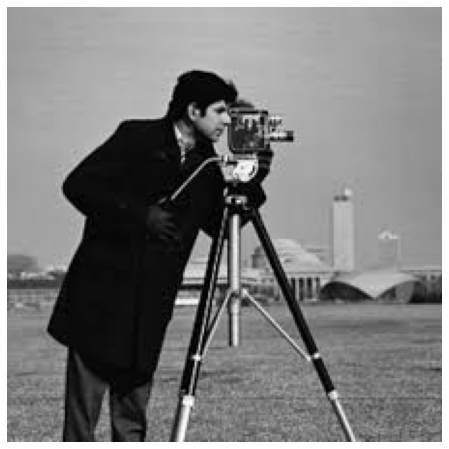

In [26]:
plt.figure(figsize=(14, 8)) 
plt.axis("off")
plt.imshow(cv2.cvtColor(input_img3, cv2.COLOR_BGR2RGB));

In [22]:
# Convert Images to Grayscale

img1 = cv2.cvtColor(input_img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(input_img2, cv2.COLOR_BGR2GRAY) 
img3 = cv2.cvtColor(input_img3, cv2.COLOR_BGR2GRAY) 

In [12]:
glb_op1=global_thresholding(img1,"optimal")

In [13]:
glb_op2=global_thresholding(img2,"spectral")

In [14]:
glb_op3=global_thresholding(img3,"otsu")

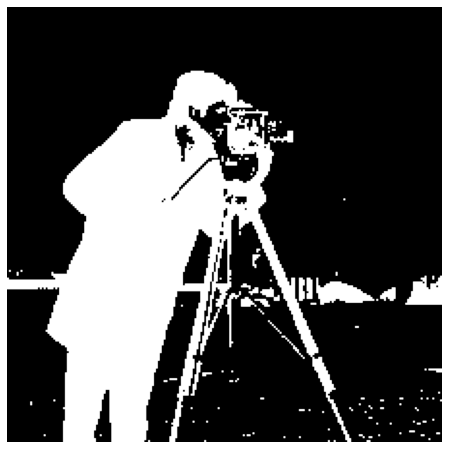

In [27]:
# Create a new figure
plt.figure(figsize=(14, 8))
plt.axis("off")
# Plot the image on the new figure
plt.imshow(glb_op3, cmap="Greys")
plt.show();  # Display the plot


In [16]:
loc_op1=local_thresholding(img1,"optimal",20)

In [17]:
loc_op2=local_thresholding(img2,"spectral",2)

In [31]:
loc_op3=local_thresholding(img3,"otsu",2)

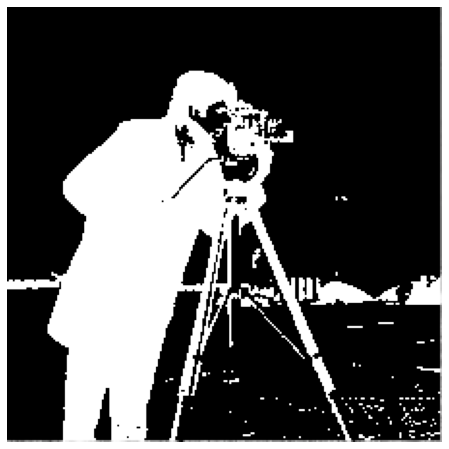

In [32]:
# Create a new figure
plt.figure(figsize=(14, 8))
plt.axis("off")
# Plot the image on the new figure
plt.imshow(loc_op3, cmap="Greys")
plt.show();  # Display the plot
